## Analyze A/B Test Results




## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  Use your dataframe to answer the questions

a. Read in the dataset and take a look at the top few rows here:

In [8]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [9]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [10]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [11]:
mean_users_converted=df.converted.mean()
mean_users_converted

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [12]:
old_page_treatment=df.query('group=="treatment" & landing_page!= "new_page"').user_id.count()

In [13]:
new_page_control=df.query('group=="control" & landing_page== "new_page"').user_id.count()

In [14]:
mismatch=old_page_treatment+new_page_control
print(mismatch)

3893


f. Do any of the rows have missing values?

In [15]:
df.isnull().values.any()

False

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

In [16]:
sub_df1=df.query('group=="treatment" & landing_page!= "new_page"')

len(sub_df1)


1965

In [17]:
sub_df2=df.query('group=="control" & landing_page== "new_page"')
len(sub_df2)

1928

In [18]:
remove=[sub_df1,sub_df2]
df_del=pd.concat(remove)

In [19]:
desired_indices = [i for i in df.index if i not in df_del.index]
df2 = df.loc[desired_indices]
df2.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            294468, 294469, 294470, 294471, 294472, 294473, 294474, 294475,
            294476, 294477],
           dtype='int64', length=290585)

In [20]:
#just checking if all mismatch is removed
len(df2.query('group=="treatment" & landing_page!= "new_page"'))

0

In [21]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [22]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [23]:
df2[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [24]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [25]:
df2.drop_duplicates('user_id',keep='first', inplace=True)

In [26]:
#check if that user id has been removed
df2.query('user_id==773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [27]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [28]:
df2.query('group=="control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [29]:
df2.query('group=="treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [30]:
prob_new_page = (df2['landing_page'] == 'new_page').mean()
prob_new_page

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Your answer goes here.**

**ANSWER:** *After cleaning the data for any mismatches and ensuring that both pages have same weightage, we studied the data. Based on the data we can say that we donot have enough evidence to conclude that the new page is better at conversions because the probability of conversions with the control group is slightly greater than the probability of conversions with the treatment group.*

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should our null and alternative hypotheses be?  We can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

***HYPOTHESIS***


***H0: p_new - p_old <=0*** 

***H1: p_new - pold >0***

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.   Use **Quiz 5** to make sure we are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [31]:
# Coversion rate is equal to the overall conversion rate for both p_new and p_old
mean_users_converted


0.11965919355605512

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [32]:
# Coversion rate is equal to the overall conversion rate for both p_new and p_old
mean_users_converted

0.11965919355605512

c. What is $n_{new}$, the number of individuals in the treatment group?

In [33]:
n_new=df2.query('group=="treatment"').user_id.count()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [34]:
n_old=df2.query('group=="control"').user_id.count()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [35]:
new_page_converted = np.random.choice([0, 1], size=n_new, p=[1-mean_users_converted, mean_users_converted])
new_page_converted


array([0, 0, 0, ..., 0, 1, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [36]:
old_page_converted = np.random.choice([0, 1], size=n_old, p=[1-mean_users_converted, mean_users_converted])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [37]:
p_new = new_page_converted .mean()
p_new

0.11905581171288969

In [38]:
p_old = old_page_converted .mean()
p_old

0.12031058551426958

In [39]:
diff=p_new-p_old
diff

-0.0012547738013798937

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [40]:
p_diffs = []

for _ in range(10000):

    new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1 - mean_users_converted), mean_users_converted])
    old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - mean_users_converted), mean_users_converted])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

p_diffs = np.asarray(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [41]:
# histogram below, clubbed with Ques j

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [42]:
new=df2.query('landing_page=="new_page"')['converted'].mean()
new

0.11880806551510564

In [43]:
old=df2.query('landing_page=="old_page"')['converted'].mean()
old

0.1203863045004612

In [44]:
obs_diff=new-old
obs_diff

-0.0015782389853555567

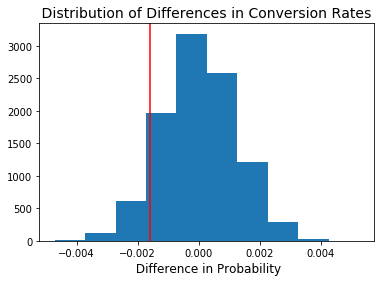

In [45]:
plt.hist(p_diffs,alpha=1);
plt.title(" Distribution of Differences in Conversion Rates ", fontsize=14)
plt.xlabel(" Difference in Probability", fontsize=12)
plt.axvline(x=obs_diff,color='red')

In [46]:
p_val=(p_diffs>obs_diff).mean()
p_val

0.90569999999999995

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Put your answer here.**

**ANSWER:** *The proportion of p_diffs greater than actual observed difference is 0.905. This is the p value. Assuming the null is true (ie the proportion of conversion with old page is more than the new page) and simulating a sample of the data,we found that the p value is more than alpha ie 0.05. This means we donot have evidence in favor of the alternative and so we fail to reject the null.Therefore we can conclude that we do not have enough evidence to say that the new page results in more conversion than the old page.*

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [49]:
import statsmodels.api as sm




In [50]:
convert_old = sum((df2.group == 'control') & (df2.converted == 1))
convert_new = sum((df2.group == 'treatment') & (df2.converted == 1)) 
n_old = sum(df2.group == 'control')
n_new = sum(df2.group == 'treatment')


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [51]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**

**ANSWER:** *The critical Z score values when using a 95% confidence level are -1.96 and +1.96 standard deviations. The p-value associated with a 95% confidence level is 0.05. If the Z score is between -1.96 and +1.96, the p-value will be larger than 0.05, and we cannot reject  null hypothsis;  If the Z score falls outside that range (for example -2.5 or +5.4), the pattern exhibited is probably too unusual to be just another version of random chance and the p-value will be small to reflect this.*

*Since the z score is within the 95% confidence level, and the p valuse is also more than 0.05 the results are consistent with our findings in parts j & k. We can therefore say that we donot have evidence to reject the null.*

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**

**ANSWER:** *We should be performing Logistic Regression because this approach is used to predict only 2 outcomes. In Linear Regression we optimize to best predict a continuous numeric variable but in this case since we have to predict correctly one of the two possible outcomes i.e.,conversion or no conversion we should use Logistic Regression.*

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [52]:
df2[['ab_page','old_page']]=pd.get_dummies(df2['landing_page'])

df2['intercept']=1
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,old_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [53]:
lr=sm.Logit(df2['converted'], df2[['ab_page','intercept']])

results=lr.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 16 Aug 2019   Pseudo R-squ.:               8.077e-06
Time:                        15:36:39   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
==============================================================================
"""

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [54]:
np.exp(results.params)

ab_page      0.985123
intercept    0.136863
dtype: float64

In [55]:
1/np.exp(results.params)

ab_page      1.015102
intercept    7.306593
dtype: float64

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Put your answer here.**

**ANSWER:** *The p value associated with ab_page is 0.190. This is more than alpha-0.05*

*In Regression P values are always given for testing if the parameter for intercept or the slope are equal to zero. In regression the null hypothesis is two tailed ( for both intercept and explanatory variable) e.g.,
H0: slope=0
H1: slope!=0*

*In Hypothesis Testing in Part II we define a null and alternate hypothesis based on our assumptions that we want to test and then the p value helps us in accepting or rejecting the null. In regression the p value tells us if the explanatory variable is statistically significant in predicting the response variable*

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**

**ANSWER:** *Adding other factors may improve model's predictability especially if those factors are correlated with the dependent variable but not correlated among themselves i.e., the explanatory variables are all independent. When adding additional terms we have to be careful about multicollinearity. If the explanatory variables are correlated with eachother it can result in multicollinearity and we may get an inaccurate result out of that regression model.*

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [56]:
df_countries=pd.read_csv('countries.csv')

In [57]:
df2=df2.join(df_countries.set_index('user_id'), on='user_id')

In [58]:
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,old_page,intercept,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,1,US


In [59]:
df2.groupby('country').size()

country
CA     14499
UK     72466
US    203619
dtype: int64

In [60]:
df2[['CA','UK','US']]=pd.get_dummies(df2['country'])
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,old_page,intercept,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,1,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,1,US,0,0,1


In [61]:
lr=sm.Logit(df2['converted'], df2[['intercept','CA','UK']])

results=lr.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 16 Aug 2019   Pseudo R-squ.:               1.521e-05
Time:                        15:36:50   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

***CONCLUSION***

*The p values for both the country are more than 0.05. This means that we fail to reject the null or the countries feature is not statistically significant in defining the difference in conversion rates for the two pages.*

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [62]:
df2['CA_page'] = df2['CA'] * df2['ab_page']
df2['UK_page'] = df2['UK'] * df2['ab_page']
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,old_page,intercept,country,CA,UK,US,CA_page,UK_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,1,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,1,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,1,US,0,0,1,0,0


In [63]:
lr=sm.Logit(df2['converted'], df2[['intercept','CA','UK','ab_page','CA_page','UK_page']])

results=lr.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 16 Aug 2019   Pseudo R-squ.:               3.482e-05
Time:                        15:36:58   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA_page       -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_page        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

***CONCLUSION***

*Based on the results, none of the countries variables and the interaction variables have any statistical significance in defining the difference in conversion rates. The p values are all greater than the alpha.* 

*We therefore fail to reject the null and conclude that these variables (interaction and countries)are not useful in explaining the conversion rates when the user is presented with the new or old page. The pseudo R square value also tells that the variability explained by the model is too low (0.00002417%)*




***RESOURCES***

https://rebeccaebarnes.github.io/2018/05/01/what-is-a-p-value

http://resources.esri.com/help/9.3/arcgisdesktop/com/gp_toolref/spatial_statistics_toolbox/what_is_a_z_score_what_is_a_p_value.htm

https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-are-the-differences-between-one-tailed-and-two-tailed-tests/

https://mashimo.wordpress.com/2017/07/26/logistic-regression-with-python-statsmodels/

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!



## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [64]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0